Files already downloaded and verified
Files already downloaded and verified

Training model: ReLU
ReLU - Epoch [10/100]: Train Loss = 0.7732, Val Loss = 0.8267
ReLU - Epoch [20/100]: Train Loss = 0.6323, Val Loss = 0.7297
ReLU - Epoch [30/100]: Train Loss = 0.5642, Val Loss = 0.7226
ReLU - Epoch [40/100]: Train Loss = 0.5146, Val Loss = 0.6775
ReLU - Epoch [50/100]: Train Loss = 0.4779, Val Loss = 0.6807
ReLU - Epoch [60/100]: Train Loss = 0.4526, Val Loss = 0.7001
ReLU - Epoch [70/100]: Train Loss = 0.4290, Val Loss = 0.6980
ReLU - Epoch [80/100]: Train Loss = 0.4121, Val Loss = 0.6756
ReLU - Epoch [90/100]: Train Loss = 0.3973, Val Loss = 0.7105
ReLU - Epoch [100/100]: Train Loss = 0.3879, Val Loss = 0.7056
ReLU - Test Accuracy: 79.86%

Training model: GELU
GELU - Epoch [10/100]: Train Loss = 0.6293, Val Loss = 0.7453
GELU - Epoch [20/100]: Train Loss = 0.4797, Val Loss = 0.7036
GELU - Epoch [30/100]: Train Loss = 0.3931, Val Loss = 0.6966
GELU - Epoch [40/100]: Train Loss = 0.3469, 

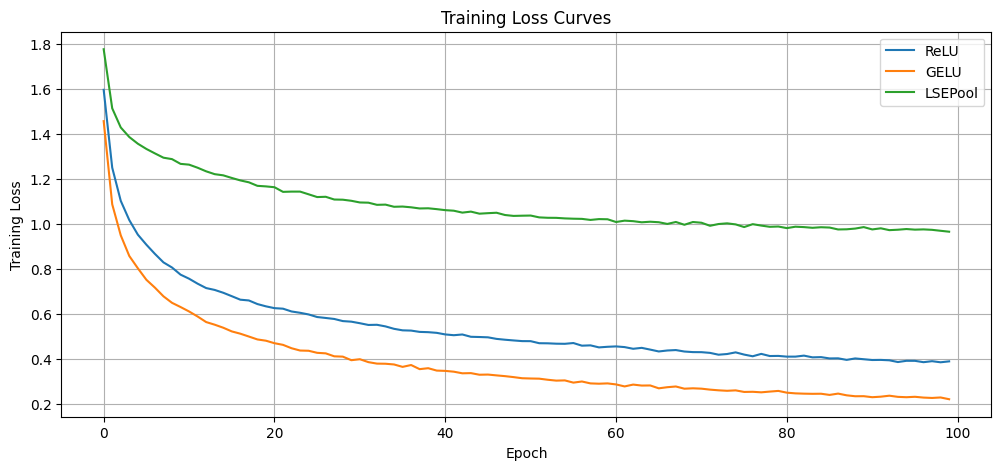

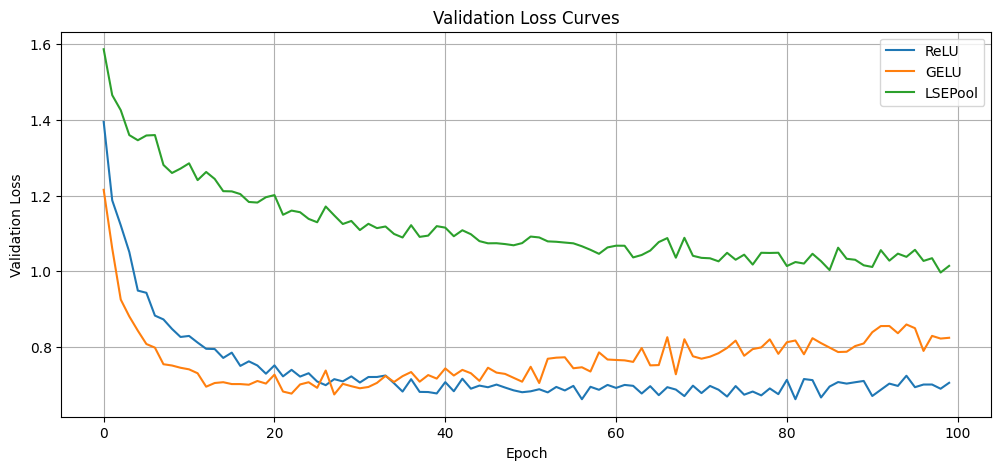


Final Test Accuracies:
ReLU: 79.86%
GELU: 80.94%
LSEPool: 69.71%


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# -----------------------------
# Define a log-sum-exp pooling module.
# -----------------------------
class LogSumExpPool2d(nn.Module):
    def __init__(self, kernel_size=2, stride=2, beta=5.0):
        """
        A smooth pooling operator that computes, for each pooling window:
          LSE = (1/beta)*log(sum(exp(beta * x)))
        When beta -> infinity, this approximates max pooling.
        """
        super(LogSumExpPool2d, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.beta = beta

    def forward(self, x):
        # x shape: (N, C, H, W)
        N, C, H, W = x.shape
        # Unfold into patches; each patch is of size (kernel_size*kernel_size)
        patches = torch.nn.functional.unfold(x, kernel_size=self.kernel_size, stride=self.stride)
        # patches shape: (N, C*ks*ks, L) where L = number of pooling windows per image
        # Reshape to (N, C, ks*ks, L)
        patches = patches.view(N, C, self.kernel_size * self.kernel_size, -1)
        # Apply logsumexp along the patch dimension (dim=2)
        # Note: for numerical stability, torch.logsumexp is used.
        lse = torch.logsumexp(self.beta * patches, dim=2) / self.beta
        # lse shape: (N, C, L) -> reshape to (N, C, H_out, W_out)
        H_out = (H - self.kernel_size) // self.stride + 1
        W_out = (W - self.kernel_size) // self.stride + 1
        return lse.view(N, C, H_out, W_out)

# -----------------------------
# Define two CNN models: one with activation functions, and one using LSE pooling and no activation.
# -----------------------------
# Model with standard activation (we'll later instantiate for ReLU and GELU)
class ConvNetWithActivation(nn.Module):
    def __init__(self, activation_fn):
        super(ConvNetWithActivation, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.act1 = activation_fn
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.act2 = activation_fn
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.act_fc = activation_fn  # optional activation on the FC layer
        self.fc2 = nn.Linear(256, 10)
    
    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.act_fc(self.fc1(x))
        x = self.fc2(x)
        return x

# Model using LSE pooling in place of max pooling and *no* activation functions in the convolutional layers.
class ConvNetLSEPool(nn.Module):
    def __init__(self, beta=5.0, kernel_size=2, stride=2):
        super(ConvNetLSEPool, self).__init__()
        self.beta = beta
        self.kernel_size = kernel_size
        self.stride = stride
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.lse_pool1 = LogSumExpPool2d(kernel_size=kernel_size, stride=stride, beta=beta)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.lse_pool2 = LogSumExpPool2d(kernel_size=kernel_size, stride=stride, beta=beta)
        
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        # In this variant we deliberately leave off any activation in the fully connected layers too.
        self.fc2 = nn.Linear(256, 10)
    
    def forward(self, x):
        x = self.lse_pool1(self.conv1(x))  # no activation after conv1
        x = self.lse_pool2(self.conv2(x))  # no activation after conv2
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

# -----------------------------
# Prepare CIFAR-10 data with training/validation split.
# -----------------------------
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2023, 0.1994, 0.2010]),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2023, 0.1994, 0.2010]),
])

full_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Split training data: 90% train, 10% validation.
train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

# -----------------------------
# Training settings
# -----------------------------
epochs = 100
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()

# Dictionary to hold models, their training and validation loss histories, and test accuracies.
models = {
    "ReLU": ConvNetWithActivation(nn.ReLU()),
    "GELU": ConvNetWithActivation(nn.GELU()),
    "LSEPool": ConvNetLSEPool(beta=5.0)  # using beta=5 as an example
}

for key in models:
    models[key] = models[key].to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

train_loss_histories = {}
val_loss_histories = {}
test_accuracies = {}

# -----------------------------
# Training loop for each model variant.
# -----------------------------
for model_name, model in models.items():
    print(f"\nTraining model: {model_name}")
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(model.device if hasattr(model, 'device') else next(model.parameters()).device), labels.to(model.device if hasattr(model, 'device') else next(model.parameters()).device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * images.size(0)
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        # Validation
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(model.device if hasattr(model, 'device') else next(model.parameters()).device), labels.to(model.device if hasattr(model, 'device') else next(model.parameters()).device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * images.size(0)
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f"{model_name} - Epoch [{epoch+1}/{epochs}]: Train Loss = {epoch_train_loss:.4f}, Val Loss = {epoch_val_loss:.4f}")
    
    train_loss_histories[model_name] = train_losses
    val_loss_histories[model_name] = val_losses

    # Evaluate on test set.
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(model.device if hasattr(model, 'device') else next(model.parameters()).device), labels.to(model.device if hasattr(model, 'device') else next(model.parameters()).device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_acc = 100.0 * correct / total
    test_accuracies[model_name] = test_acc
    print(f"{model_name} - Test Accuracy: {test_acc:.2f}%")

# -----------------------------
# Plot the training loss curves.
# -----------------------------
plt.figure(figsize=(12, 5))
for model_name, losses in train_loss_histories.items():
    plt.plot(losses, label=model_name)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Curves")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# Plot the validation loss curves.
# -----------------------------
plt.figure(figsize=(12, 5))
for model_name, losses in val_loss_histories.items():
    plt.plot(losses, label=model_name)
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Curves")
plt.legend()
plt.grid(True)
plt.show()

# Print final test accuracies.
print("\nFinal Test Accuracies:")
for model_name, acc in test_accuracies.items():
    print(f"{model_name}: {acc:.2f}%")


Below is an example that builds a “deeper” CNN architecture (with three convolutional blocks, each with two conv layers) and then compares three variants on CIFAR‑10:

1. ReLU variant: Uses ReLU as the activation after each convolution, with standard max pooling.
2. GELU variant: Uses GELU as the activation function, again with standard max pooling.
3. LSEPool variant: Omits any explicit activation functions and instead relies on a custom log‑sum‑exp pooling layer (a smooth, differentiable approximation to max pooling) for its non-linearity.

In the code, you’ll see many comments explaining that we are building a deeper network (i.e. more conv layers and pooling stages) to better reveal differences between these choices. Running this on a GPU is recommended because deeper networks on CIFAR‑10 can be computationally heavy.

Files already downloaded and verified
Files already downloaded and verified
Using device: cuda

Training deep network with ReLU variant
ReLU - Epoch [10/100]: Train Loss = 0.4526, Val Loss = 0.5623
ReLU - Epoch [20/100]: Train Loss = 0.2987, Val Loss = 0.5251
ReLU - Epoch [30/100]: Train Loss = 0.2371, Val Loss = 0.5280
ReLU - Epoch [40/100]: Train Loss = 0.1981, Val Loss = 0.5437
ReLU - Epoch [50/100]: Train Loss = 0.1776, Val Loss = 0.5890
ReLU - Epoch [60/100]: Train Loss = 0.1706, Val Loss = 0.6307
ReLU - Epoch [70/100]: Train Loss = 0.1599, Val Loss = 0.6334
ReLU - Epoch [80/100]: Train Loss = 0.1538, Val Loss = 0.6398
ReLU - Epoch [90/100]: Train Loss = 0.1534, Val Loss = 0.6610
ReLU - Epoch [100/100]: Train Loss = 0.1410, Val Loss = 0.7072
ReLU - Test Accuracy: 85.94%

Training deep network with GELU variant
GELU - Epoch [10/100]: Train Loss = 0.3350, Val Loss = 0.5274
GELU - Epoch [20/100]: Train Loss = 0.2149, Val Loss = 0.4812
GELU - Epoch [30/100]: Train Loss = 0.1759, Val L

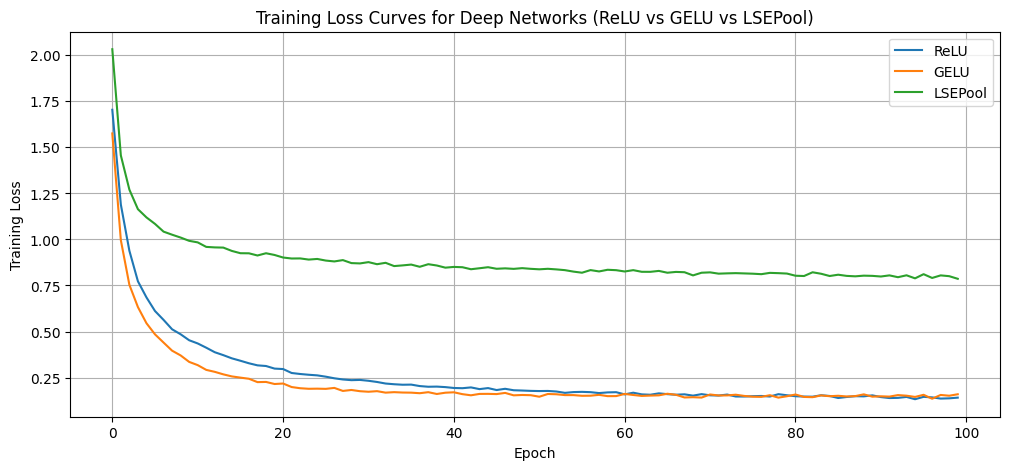

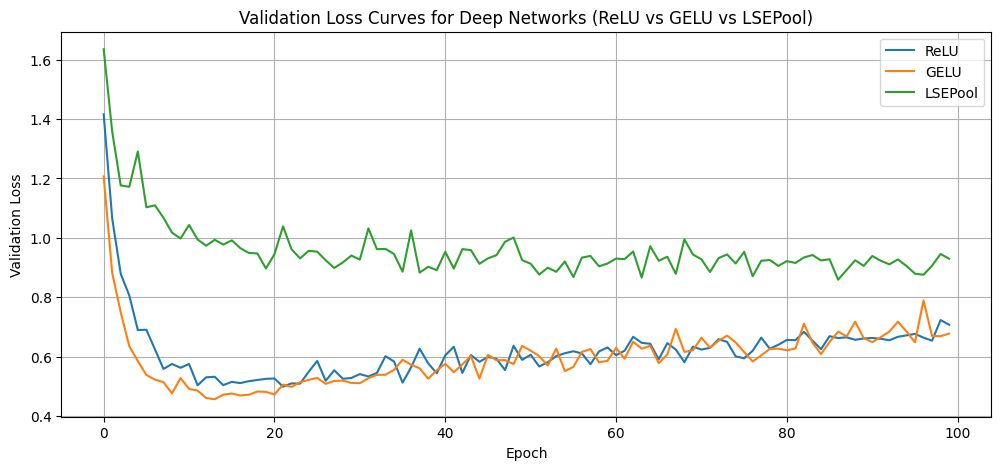


Final Test Accuracies:
ReLU: 85.94%
GELU: 86.73%
LSEPool: 73.60%


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# ========================================================
# Define a LogSumExp Pooling Module
# ========================================================
class LogSumExpPool2d(nn.Module):
    def __init__(self, kernel_size=2, stride=2, beta=5.0):
        """
        This module implements a smooth pooling operator using the log-sum-exp function.
        For each pooling window, it computes:
           LSE(x) = (1/beta) * log(sum(exp(beta * x_i)))
        As beta increases, LSE(x) approaches the max of the window.
        """
        super(LogSumExpPool2d, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.beta = beta

    def forward(self, x):
        # x shape: (N, C, H, W)
        N, C, H, W = x.shape
        # Unfold: extract sliding patches of size kernel_size x kernel_size.
        # After unfold, shape is (N, C * kernel_size^2, L) where L = number of patches per image.
        patches = torch.nn.functional.unfold(x, kernel_size=self.kernel_size, stride=self.stride)
        # Reshape to (N, C, kernel_size^2, L) so we can pool within each channel.
        patches = patches.view(N, C, self.kernel_size * self.kernel_size, -1)
        # Apply the log-sum-exp along the patch dimension (axis 2).
        lse = torch.logsumexp(self.beta * patches, dim=2) / self.beta
        # Calculate new spatial dimensions.
        H_out = (H - self.kernel_size) // self.stride + 1
        W_out = (W - self.kernel_size) // self.stride + 1
        # Reshape back to (N, C, H_out, W_out)
        return lse.view(N, C, H_out, W_out)

# ========================================================
# Define a deep CNN using standard activations (for ReLU and GELU variants)
# ========================================================
class DeepCNNWithActivation(nn.Module):
    def __init__(self, activation_fn):
        """
        This network is designed to be 'deep' relative to the simple 2-layer model.
        It consists of three convolutional blocks (each with two convolution layers)
        followed by standard max pooling.
        """
        super(DeepCNNWithActivation, self).__init__()
        # Block 1: Input 32x32 -> Output 16x16
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.act1 = activation_fn
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.act2 = activation_fn
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Block 2: 16x16 -> 8x8
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.act3 = activation_fn
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.act4 = activation_fn
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Block 3: 8x8 -> 4x4
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.act5 = activation_fn
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.act6 = activation_fn
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.act_fc = activation_fn
        self.fc2 = nn.Linear(512, 10)
    
    def forward(self, x):
        # Block 1
        x = self.act1(self.conv1(x))
        x = self.act2(self.conv2(x))
        x = self.pool1(x)
        
        # Block 2
        x = self.act3(self.conv3(x))
        x = self.act4(self.conv4(x))
        x = self.pool2(x)
        
        # Block 3
        x = self.act5(self.conv5(x))
        x = self.act6(self.conv6(x))
        x = self.pool3(x)
        
        # Flatten and apply fully-connected layers.
        x = x.view(x.size(0), -1)
        x = self.act_fc(self.fc1(x))
        x = self.fc2(x)
        return x

# ========================================================
# Define a deep CNN that uses LSE Pooling instead of explicit activations.
# ========================================================
class DeepCNNWithLSEPool(nn.Module):
    def __init__(self, beta=5.0):
        """
        In this variant we remove explicit non-linear activations.
        Instead, we rely on the non-linearity provided by the log-sum-exp pooling layers.
        Each pooling operation is a smooth approximation to max pooling.
        """
        super(DeepCNNWithLSEPool, self).__init__()
        # Block 1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.lse_pool1 = LogSumExpPool2d(kernel_size=2, stride=2, beta=beta)
        
        # Block 2
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.lse_pool2 = LogSumExpPool2d(kernel_size=2, stride=2, beta=beta)
        
        # Block 3
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.lse_pool3 = LogSumExpPool2d(kernel_size=2, stride=2, beta=beta)
        
        # Fully connected layers (we omit any activation here)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
    
    def forward(self, x):
        # Block 1: Apply two convolutions then smooth pooling.
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.lse_pool1(x)
        
        # Block 2:
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.lse_pool2(x)
        
        # Block 3:
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.lse_pool3(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

# ========================================================
# Data Preparation: CIFAR-10 with Training/Validation Split
# ========================================================
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2023, 0.1994, 0.2010]),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2023, 0.1994, 0.2010]),
])

full_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Split full training set into 90% training and 10% validation.
train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

# ========================================================
# Training Settings: We now train these deeper networks to compare
# the performance of ReLU, GELU, and LSEPool variants.
# ========================================================
epochs = 100
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Instantiate our three deep models.
models = {
    "ReLU": DeepCNNWithActivation(nn.ReLU()),
    "GELU": DeepCNNWithActivation(nn.GELU()),
    "LSEPool": DeepCNNWithLSEPool(beta=5.0)
}

# Move models to device.
for key in models:
    models[key] = models[key].to(device)

train_loss_histories = {}
val_loss_histories = {}
test_accuracies = {}

# ========================================================
# Training Loop for Each Model Variant
# ========================================================
for model_name, model in models.items():
    print(f"\nTraining deep network with {model_name} variant")
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * images.size(0)
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        # Validation loop.
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * images.size(0)
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f"{model_name} - Epoch [{epoch+1}/{epochs}]: Train Loss = {epoch_train_loss:.4f}, Val Loss = {epoch_val_loss:.4f}")
    
    train_loss_histories[model_name] = train_losses
    val_loss_histories[model_name] = val_losses

    # Evaluate on the test set.
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_acc = 100.0 * correct / total
    test_accuracies[model_name] = test_acc
    print(f"{model_name} - Test Accuracy: {test_acc:.2f}%")

# ========================================================
# Plotting: Training and Validation Loss Curves
# ========================================================
plt.figure(figsize=(12, 5))
for model_name, losses in train_loss_histories.items():
    plt.plot(losses, label=model_name)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Curves for Deep Networks (ReLU vs GELU vs LSEPool)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
for model_name, losses in val_loss_histories.items():
    plt.plot(losses, label=model_name)
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Curves for Deep Networks (ReLU vs GELU vs LSEPool)")
plt.legend()
plt.grid(True)
plt.show()

# ========================================================
# Print Final Test Accuracies
# ========================================================
print("\nFinal Test Accuracies:")
for model_name, acc in test_accuracies.items():
    print(f"{model_name}: {acc:.2f}%")
